In [168]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Introduction

Dans ce notebook, on se propose de modéliser un TVAR d'ordre d quelconque à partir de l'algorithme de Levinson-Durbin. On va aussi construire un estimateur en ligne par la méthode du NLMS et observer l'influence du choix du pas de descente $\mu$ sur l'erreur d'estimation obtenue $\forall t$ par :
\begin{equation}
MSE(\mu, t) = ||\theta_t - \hat\theta_t(\mu)||^2
\end{equation}

  On se propose enfin de construire un predicteur par aggregation à partir de divers estimateurs construits précédement et en tirer des propriétés de convergence vers le processus $X$ à partir de l'erreur de prédiction $\forall t$:
\begin{equation}
\epsilon(t) = ||X_t - X^{pred}_t||^2
\end{equation}

### Génération d'un TVAR(d)

On génère un TVAR à partir de corrélations partielles choisies au hasard dans l'algorithme de Levinson.

In [201]:
def random_polynom(p, T):
    """genere un polynome dans d'ordre au plus d avec des coeff tirés aléatoirement dans [-10, 10]"""

    u = np.arange(T, 2*T) # horizon des temps normalisés
    ordre = np.random.choice(p) + 1 #on exclue l'ordre 0 des choix possibles et on ajoute d à la place
    coeffs = 4 * np.random.rand(ordre+1) - 8
    
    out = np.zeros(T)
    for k in np.arange(ordre+1):
        out += coeffs[k] * np.power(u, k)
        
    return out / (1.1 *max(abs(out)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in power


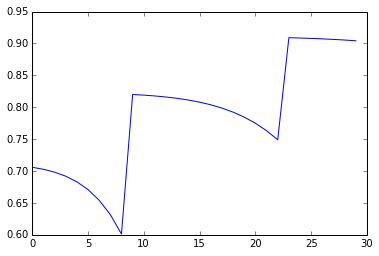

In [202]:
poly = random_polynom(30, 30)

plt.plot(poly)

In [203]:
def generation_TVAR(d, T, epsilon):
    
    """generation des coefficients du TVAR par les corrélations partielles de l'algorithme de Levinson"""
    
    ordre = 3
    kappa = np.zeros((d,T))
    for k in np.arange(d):
        kappa[k,:] = random_polynom(ordre, T)
    
    theta = np.matrix(np.zeros((d,T)))
    theta_inter = np.matrix(np.zeros((d,d)))
    X = epsilon
    
    for t in np.arange(T):
        for k in np.arange(d):
            theta_inter[k,k] = kappa[k,t]
        for p in np.arange(1, d):
            for k in np.arange(0, p-1):
                theta_inter[k,p] = theta_inter[k, p-1] - kappa[p,t] * theta_inter[p-k,p-1]
        theta[:,t] = theta_inter[:,d-1]

        X[T + t] += np.dot(X[T+t-d:T+t][::-1], theta[:,t])
        
    return X, theta

[[ 0.        ]
 [-0.73921547]
 [ 0.        ]
 [ 0.        ]
 [-0.6869344 ]]


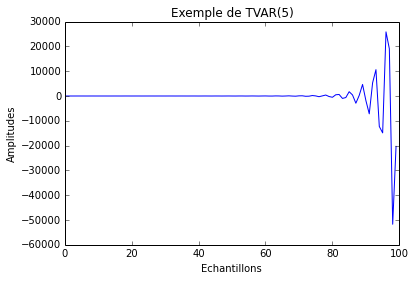

In [211]:
d = 5
T = int(1e2)
epsilon = np.random.randn(2*T)
X, theta = generation_TVAR(d, T, epsilon)

plt.plot(X[T:])
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple de TVAR({})".format(d))
plt.show()

### Analyse spectrale

In [173]:
from scipy.fftpack import fft

def dsp(theta, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(1./abs(fft(theta[:,t].T, N)) ** 2).T
        
    lambd = np.arange(N, dtype = 'double')/N
        
    return lambd, dsp_array

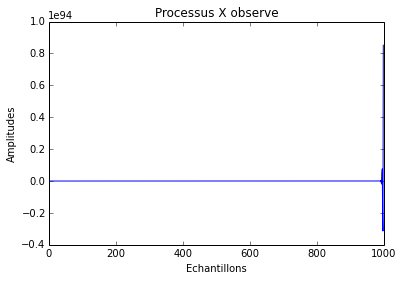

In [174]:
d = 8
T = int(1e3)
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR(d, T, epsilon)

plt.figure()
plt.plot(X[T:])
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Processus X observe")

### Construction d'un estimateur en ligne

In [175]:
from scipy.linalg import norm

def generation_est(X, d, T, mu):

    theta_est = np.matrix(np.zeros((d,T)))
    X_est = np.zeros(T)
    
    for k in (np.arange(T)): # on fait T itérations
        XX = X[T+k-d:T+k][::-1]
        
        if k==0:
            theta_est[:,k] = np.matrix(mu * X[T+k] * XX / (1 + mu * norm(XX) ** 2)).T 
        else:
            theta_est[:,k] = np.matrix(theta_est[:,k-1].T + mu * (X[T+k] - np.dot(XX, theta_est[:,k-1])) * XX / (1 + mu * norm(XX) ** 2)).T  

        X_est[k] = np.dot(XX, theta_est[:,k])
        
    return X_est, theta_est

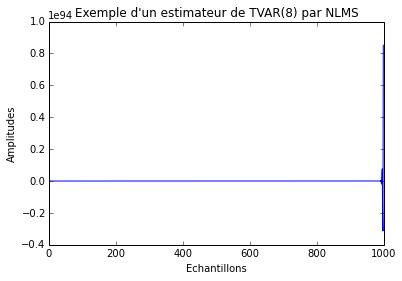

In [176]:
X_est, theta_est = generation_est(X, d, T, 0.05)

plt.plot(X[T:])
#plt.plot(X_est[:T], 'r')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple d'un estimateur de TVAR({}) par NLMS".format(d))

### Estimation par aggregation

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide


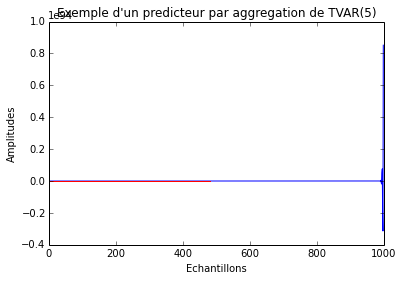

In [177]:
# INITIALISATION

T = int(1e3)
d = 5
log_mu = np.arange(-2, 0, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)
estimations = np.matrix(np.zeros((N, T)))

for k in np.arange(N):
    estimations[k,:] = generation_est(X, d, T, mu[k])[0]

eta = 1
strategy = 1
alpha = 1./N * np.ones(N)
pred = np.zeros(T)

# ALGO D'ACCUMULATION

for t in np.arange(T):
    #print (np.dot(alpha, estimations[:,t]).shape)
    pred[t] = np.dot(alpha, estimations[:,t])
    
    if t > 0:
        v = np.zeros(N)
        for i in np.arange(N):
            if strategy == 1:
                v[i] = alpha[i] * np.exp(-2*eta*(pred[t-1]-X[t-1])*estimations[i,t-1])
            else:
                v[i] = alpha[i] * np.exp(-eta*(estimations[i,t-1]-X[t-1])**2)
        alpha = v / np.sum(v)
      
plt.plot(X[T:], 'b')
plt.plot(pred, 'r')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple d'un predicteur par aggregation de TVAR({})".format(d))


In [178]:
#FACTORISATION EN FONCTION

def aggregation(X, estimations, T, eta, strategy = 1):
    
    """Retourne un predicteur par aggregation"""
    
    N = len(estimations[:,0])
    pred = np.zeros(T)
    alpha = 1./N * np.ones(N)
    
    for t in np.arange(T):
    
        if t > 0:
            v = np.zeros(N)
            for i in np.arange(N):
                if strategy == 1:
                    v[i] = alpha[i] * np.exp(-2*eta*(pred[t-1]-X[t-1])*estimations[i,t-1])
                else:
                    v[i] = alpha[i] * np.exp(-eta*(estimations[i,t-1]-X[t-1])**2)
            alpha = v / np.sum(v)
            
        pred[t] = np.dot(alpha, estimations[:,t])
            
    return pred

### Exemple 1 : Estimation par aggregation d'un TVAR(d)

#### Test de différentes valeurs de $\mu$

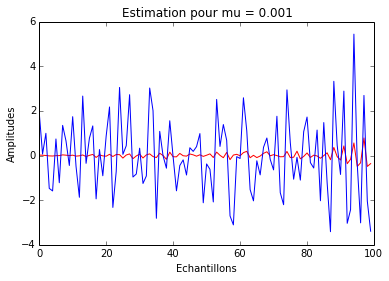

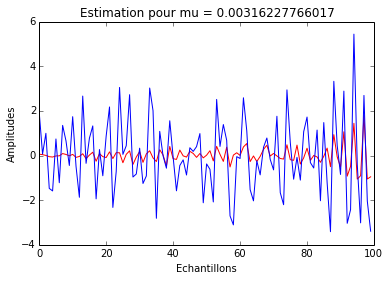

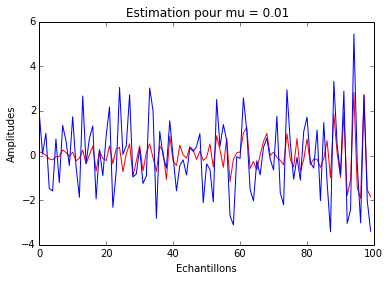

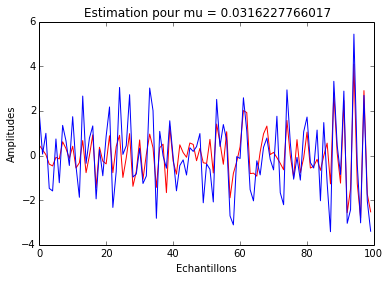

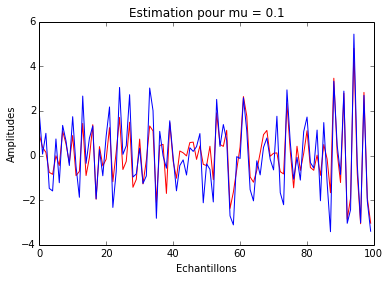

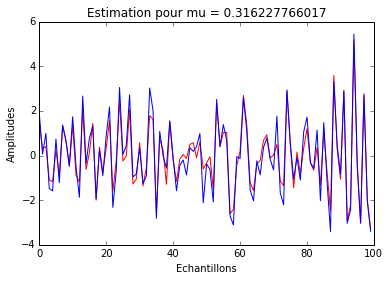

In [196]:
#initalisation
T = int(1e2)
d = 4
epsilon = np.random.randn(2*T)
X = generation_TVAR(d, T, epsilon)[0]

# Estimation
log_mu = np.arange(-3, 0, 0.5)
N = len(log_mu)
mu = np.power(10, log_mu)
estimations = np.matrix(np.zeros((N, T)))
MSE = np.zeros(N)

for k in np.arange(N):
    estimations[k,:], theta_est = generation_est(X, d, T, mu[k])
    MSE[k] = 1./ T * norm(X[T:] - estimations[k,:]) ** 2
    
    plt.figure()
    plt.plot(estimations[k,:].T, 'r')
    plt.plot(X[T:])
    plt.xlabel("Echantillons")
    plt.ylabel("Amplitudes")
    plt.title("Estimation pour mu = {}".format(mu[k]))

#### EQM en fonction de $\mu$

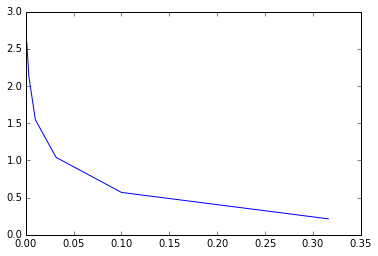

In [197]:
plt.plot(mu, MSE)

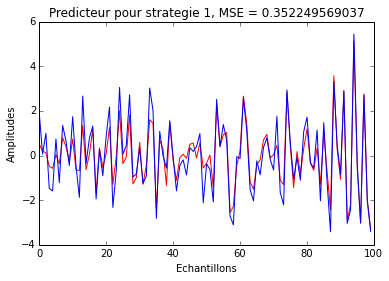

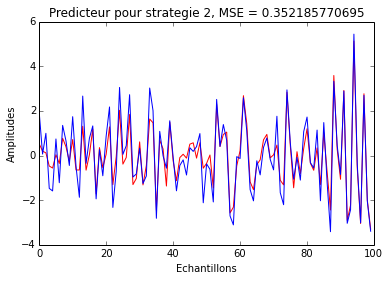

In [198]:
pred1 = aggregation(X[T:], estimations, T, 0.1, 1)
pred2 = aggregation(X[T:], estimations, T, 0.1, 2)
    
plt.figure()
plt.plot(pred1, 'r')

plt.plot(X[T:], 'b')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Predicteur pour strategie 1, MSE = {}".format(1./T * norm(X[T:] - pred1)**2))

plt.figure()
plt.plot(pred2, 'r')
plt.plot(X[T:], 'b')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Predicteur pour strategie 2, MSE = {}".format(1./T * norm(X[T:] - pred2)**2))

### Exemple 1 : un TVAR(d) quelconque

In [200]:
d = 20
T = int(5e2)
mu = 5e-2
epsilon = np.random.randn(2*T)

theta = generation_TVAR(d, T, epsilon)[1]
theta_est = generation_est(X, d, T, mu)[1]

plt.figure()
plt.plot(theta[:,T/2], 'b', label = 'X')
plt.plot(theta_est[:,T/2], 'r', label = 'X_est')
plt.title("Processus reel et son estimation")

IndexError: index out of bounds

#### Estimation paramétrique

In [ ]:
N = 2**12

coeffs = np.ones((d+1,T))
coeffs[1:,:] = -theta #polynome caractértistique

coeffs_est = np.ones((d+1,T))
coeffs_est[1:,:] = -theta_est #polynome caractértistique

f, dsp_X = dsp(coeffs, T, N)
f, dsp_X_est = dsp(coeffs_est, T, N)


roots = np.roots(coeffs[:,0][::-1])
#print("Les racines approche du polynome caracteristique sont {}".format(roots))
angles = (np.angle(roots) + np.pi) / (2*np.pi)
#print("Les phases associees sont {}".format(angles))

        

lambd = np.arange(N, dtype = 'double') / N

plt.figure()
plt.plot(lambd, dsp_X[:,0]/np.max(abs(dsp_X[:,0])), 'b', label ='vraie DSP')
for k in np.arange(d):
    plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP et racines du polynome caracteristique")

plt.figure()
plt.plot(lambd, dsp_X_est[:,0]/np.max(abs(dsp_X_est[:,0])), 'b', label = 'DSP estimee')
for k in np.arange(d):
    plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP estimee et racines du polynome caracteristique")

#### Estimation non-paramétrique

In [ ]:
from scipy.signal import periodogram

N = 2**12

f, Pxx = periodogram(X, nfft = N)
f, Pxx_est = periodogram(X_est, nfft = N)

plt.figure()
plt.plot(f, Pxx/np.max(abs(Pxx)), 'b', label ='vraie DSP')
for k in np.arange(d):
    if angles[k] >= 0 and angles[k] < 0.5:
        plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme des observations")
        
plt.figure()
plt.plot(f, Pxx_est/np.max(abs(Pxx_est)), 'b', label = 'DSP estimee')
for k in np.arange(d):
    if angles[k] >= 0 and angles[k] < 0.5:
        plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme de l'estimation")

### Exemple 2 : "a-e-i-o-u"

In [ ]:
from scipy.io.wavfile import *
import IPython


Fs, X = read("data/aeiou.wav")
X = np.float64(X)

d = 2 #On se donne un TVAR long quitte à avoir certains coefficients nuls à la fin
T = len(X)
mu = 1e-2
temp = np.random.randn(2*T)
temp[T:] = X #on ajoute du bruit au début pour simuler le silence au début de la trame

X_est, theta_est = generation_est(temp, d, T, mu)

max_X = abs(max(X))
t = np.arange(T, dtype = "double")/Fs
plt.figure()
plt.plot(t, X/max_X, 'b', label="aeiou")
plt.title("aeiou")

plt.figure()
plt.plot(t, X_est/max_X, 'r', label="estimation")
plt.title("estimation")

print(norm((X - X_est)/max_X) ** 2)

IPython.display.Audio(X_est, rate=Fs)